# **Install Dependencies**

In [ ]:
# ==============================
# 0. Install dependencies
# ==============================
!pip install transformers datasets torch scikit-learn opacus shap matplotlib seaborn fastapi uvicorn nest-asyncio pyngrok streamlit requests -q

import nest_asyncio
nest_asyncio.apply()

# **Import libraries**

In [ ]:
# ==============================
# 1. Imports
# ==============================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import XLMRobertaTokenizer, XLMRobertaModel

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import shap
import random
import requests

# **Load dataset**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load dataset from GitHub
url = "https://raw.githubusercontent.com/frehiwot-g-girmay/Demo-Project/main/harassmentdataset.csv"
dataset_df = pd.read_csv(url, encoding='latin1')
# Inspect dataset
print("Columns:", dataset_df.columns.tolist())
print(dataset_df.head())



Columns: ['hate_category_1', 'hate_category_2', 'explanation', 'english', 'Amharic', 'afaan_oromo', 'Tigregna', 'otherspellings']
  hate_category_1 hate_category_2  \
0          Gender             NaN   
1          Gender             NaN   
2          Gender             NaN   
3          Gender             NaN   
4          Gender             NaN   

                                         explanation  \
0  According to CIR & TikTok workshop participant...   
1  According to CIR & TikTok workshop participant...   
2  According to CIR & TikTok workshop participant...   
3  According to CIR & TikTok workshop participant...   
4  According to CIR & TikTok workshop participant...   

                                 english  \
0                            a good wife   
1    a good wife keeps her husband happy   
2            a good wife knows her place   
3       a good wife wouldnât post this   
4  a man who marries her deserves thanks   

                                             

In [ ]:
# Check for missing values
missing_values = dataset_df.isnull().sum()

print("Missing values per column:")
print(missing_values[missing_values > 0])

Missing values per column:
hate_category_1      22
hate_category_2    1184
explanation          69
english             599
Amharic             524
afaan_oromo         315
Tigregna            685
otherspellings      986
dtype: int64


In [ ]:
# Identify and drop 'Unnamed' columns
unwanted_columns = [col for col in dataset_df.columns if 'Unnamed:' in col]

if unwanted_columns:
    dataset_df = dataset_df.drop(columns=unwanted_columns)
    print(f"Dropped columns: {unwanted_columns}")
else:
    print("No 'Unnamed' columns found to drop.")

print("Remaining columns:", dataset_df.columns.tolist())
print(dataset_df.head())

No 'Unnamed' columns found to drop.
Remaining columns: ['hate_category_1', 'hate_category_2', 'explanation', 'english', 'Amharic', 'afaan_oromo', 'Tigregna', 'otherspellings']
  hate_category_1 hate_category_2  \
0          Gender             NaN   
1          Gender             NaN   
2          Gender             NaN   
3          Gender             NaN   
4          Gender             NaN   

                                         explanation  \
0  According to CIR & TikTok workshop participant...   
1  According to CIR & TikTok workshop participant...   
2  According to CIR & TikTok workshop participant...   
3  According to CIR & TikTok workshop participant...   
4  According to CIR & TikTok workshop participant...   

                                 english  \
0                            a good wife   
1    a good wife keeps her husband happy   
2            a good wife knows her place   
3       a good wife wouldnât post this   
4  a man who marries her deserves thanks   


In [ ]:
# Impute missing values in 'hate_category_2' and 'otherspellings' with 'Unknown'
dataset_df['hate_category_2'] = dataset_df['hate_category_2'].fillna('Unknown')
dataset_df['otherspellings'] = dataset_df['otherspellings'].fillna('Unknown')

print("Missing values after imputation:")
print(dataset_df[['hate_category_2', 'otherspellings']].isnull().sum())

Missing values after imputation:
hate_category_2    0
otherspellings     0
dtype: int64


# **Preprocess dataset**

In [ ]:
import pandas as pd

# Make sure column names are standardized to lowercase and stripped
dataset_df.columns = [c.strip().lower() for c in dataset_df.columns]

# Map existing columns to 'text' and 'label'
dataset_df = dataset_df.rename(columns={'english': 'text', 'hate_category_1': 'label'})

# Ensure 'text' and 'label' exist after renaming
if 'text' not in dataset_df.columns:
    raise ValueError("'text' column not found in dataset")
if 'label' not in dataset_df.columns:
    raise ValueError("'label' column not found in dataset")

# Fill any NaN values in the 'text' column with an empty string before cleaning
dataset_df['text'] = dataset_df['text'].fillna('')

# Clean text: lowercase + strip
dataset_df['text'] = dataset_df['text'].astype(str).str.lower().str.strip()

# Optional: remove empty rows (if 'text' becomes empty after cleaning)
dataset_df = dataset_df[dataset_df['text'] != ""]

print("Dataset ready. Label distribution:")
print(dataset_df['label'].value_counts())

Dataset ready. Label distribution:
label
Gender       384
Others        74
Political     62
Ethnic        53
Religious     42
Name: count, dtype: int64


# **Split train and validation sets**

In [ ]:
# Drop rows where 'label' is NaN before splitting for stratification
dataset_df_cleaned = dataset_df.dropna(subset=['label'])

train_texts, val_texts, train_labels, val_labels = train_test_split(
    dataset_df_cleaned['text'], dataset_df_cleaned['label'], test_size=0.2, random_state=42, stratify=dataset_df_cleaned['label']
)

print(f"Training samples: {len(train_texts)}, Validation samples: {len(val_texts)}")

Training samples: 492, Validation samples: 123


# **Tokenize for Transformer**

In [ ]:
!pip install transformers datasets --quiet

from transformers import AutoTokenizer

# Use multilingual BERT
MODEL_NAME = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Tokenize
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=128)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# **Convert to PyTorch Dataset**

In [ ]:
import torch
import pandas as pd

class GBVDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        # Labels are now expected to be numerical IDs
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

# Create a consistent numerical mapping for string labels
# Ensure 'dataset_df_cleaned' is available from previous cells.
unique_labels = dataset_df_cleaned['label'].unique()
label_to_id = {label: i for i, label in enumerate(unique_labels)}

# Convert string labels in train_labels and val_labels to numerical IDs
train_labels_numerical = train_labels.map(label_to_id).values
val_labels_numerical = val_labels.map(label_to_id).values

# Create the datasets using the numerical labels
train_dataset = GBVDataset(train_encodings, train_labels_numerical)
val_dataset = GBVDataset(val_encodings, val_labels_numerical)


# **Train Transformer Model**

In [ ]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

# Number of labels
num_labels = dataset_df['label'].nunique()

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)

# Training arguments
training_args = TrainingArguments(
    output_dir="./gbv_model",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch", # Changed from evaluation_strategy
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=50,
    learning_rate=2e-5,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

# Metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train
trainer.train()

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-multilingual-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
`logging_dir` is deprecate

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,1.128760,0.626016,0.482033,0.391896,0.626016
2,1.171517,1.005912,0.674797,0.563051,0.485534,0.674797
3,1.171517,0.988343,0.650407,0.549023,0.475359,0.650407


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

TrainOutput(global_step=93, training_loss=1.067959693170363, metrics={'train_runtime': 734.7035, 'train_samples_per_second': 2.009, 'train_steps_per_second': 0.127, 'total_flos': 18963006751800.0, 'train_loss': 1.067959693170363, 'epoch': 3.0})

# **Save Model & Tokenizer**

In [ ]:
model.save_pretrained("./gbv_model")
tokenizer.save_pretrained("./gbv_model")
print("Model and tokenizer saved for inference.")


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Model and tokenizer saved for inference.


# **Install needed libraries**

In [ ]:
!pip install shap matplotlib seaborn scikit-learn --quiet


# **Evaluate model and get predictions**

In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Put model in eval mode
model.eval()

# Helper to get predictions
def get_preds(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=16)
    preds = []
    labels = []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            batch_labels = batch['labels']

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            batch_preds = torch.argmax(outputs.logits, dim=1)

            preds.extend(batch_preds.cpu().numpy())
            labels.extend(batch_labels.cpu().numpy())
    return np.array(preds), np.array(labels)

val_preds, val_labels_np = get_preds(val_dataset)


# **Confusion matrix plot**

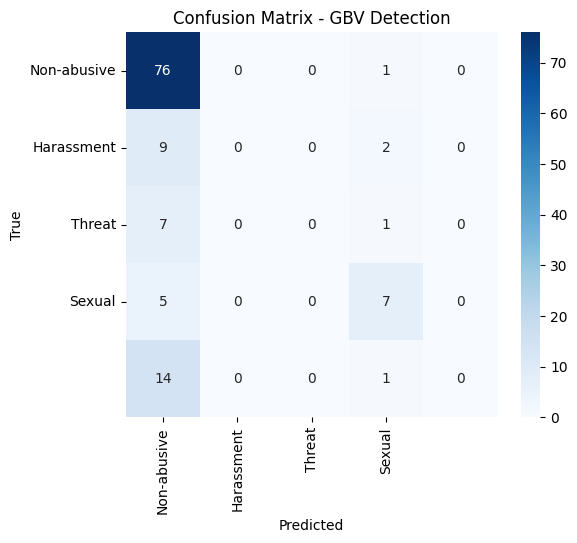

In [ ]:
cm = confusion_matrix(val_labels_np, val_preds)
labels_names = ["Non-abusive", "Harassment", "Threat", "Sexual"]

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - GBV Detection")
plt.show()


# **Classification report**

In [ ]:
labels_names = unique_labels.tolist() # Use the actual unique labels from the dataset
report = classification_report(val_labels_np, val_preds, target_names=labels_names)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

      Gender       0.68      0.99      0.81        77
      Ethnic       0.00      0.00      0.00        11
   Religious       0.00      0.00      0.00         8
   Political       0.58      0.58      0.58        12
      Others       0.00      0.00      0.00        15

    accuracy                           0.67       123
   macro avg       0.25      0.31      0.28       123
weighted avg       0.49      0.67      0.56       123



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# **Fairness / label distribution chart**

/tmp/ipython-input-4140539204.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels_names, y=counts, palette="Set2")


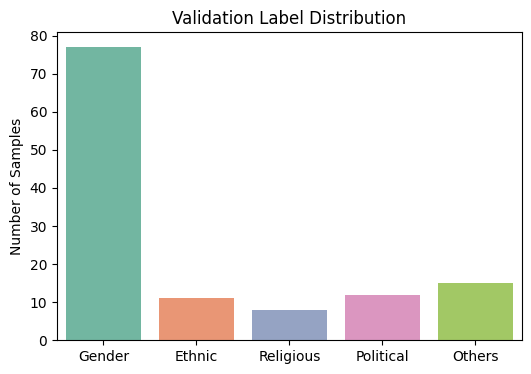

In [ ]:
# Label distribution in validation set
unique, counts = np.unique(val_labels_np, return_counts=True)
plt.figure(figsize=(6,4))
sns.barplot(x=labels_names, y=counts, palette="Set2")
plt.title("Validation Label Distribution")
plt.ylabel("Number of Samples")
plt.show()


# **Explainability using SHAP**

In [ ]:
import shap
from transformers import pipeline

# Use pipeline for simplified text classification explanation
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True)

# Select small subset for SHAP (explaining large dataset is slow)
sample_texts = val_texts[:50].tolist()

# SHAP explainer
explainer = shap.Explainer(classifier)
shap_values = explainer(sample_texts)

# Plot SHAP explanation for first example
shap.plots.text(shap_values[0])


  0%|          | 0/42 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|█         | 5/50 [00:41<01:45,  2.35s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

PartitionExplainer explainer:  16%|█▌        | 8/50 [00:50<01:47,  2.56s/it]

  0%|          | 0/56 [00:00<?, ?it/s]

PartitionExplainer explainer:  26%|██▌       | 13/50 [01:06<01:31,  2.47s/it]

  0%|          | 0/42 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|███████   | 35/50 [02:02<00:31,  2.07s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

PartitionExplainer explainer:  94%|█████████▍| 47/50 [02:37<00:07,  2.36s/it]

  0%|          | 0/90 [00:00<?, ?it/s]

PartitionExplainer explainer:  96%|█████████▌| 48/50 [02:45<00:08,  4.23s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

PartitionExplainer explainer: 51it [03:00,  3.61s/it]


# **Save evaluation plots for report**

/tmp/ipython-input-315152078.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels_names, y=counts, palette="Set2")


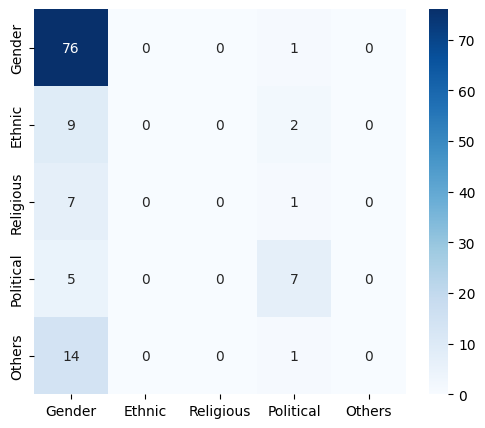

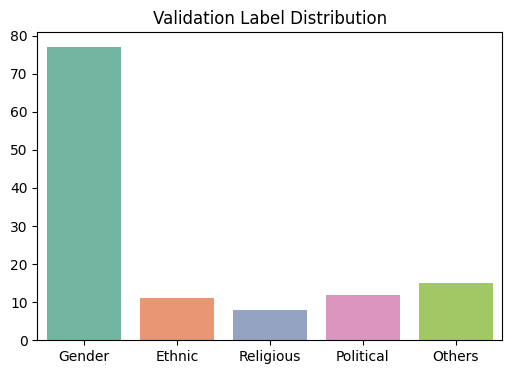

In [ ]:
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels_names, yticklabels=labels_names)
plt.savefig("confusion_matrix.png")

plt.figure(figsize=(6,4))
sns.barplot(x=labels_names, y=counts, palette="Set2")
plt.title("Validation Label Distribution")
plt.savefig("label_distribution.png")


# **Install Gradio**

In [19]:
pip install --upgrade gradio


  Using cached gradio-6.5.1-py3-none-any.whl.metadata (16 kB)
  Using cached gradio_client-2.0.3-py3-none-any.whl.metadata (7.1 kB)
  Using cached huggingface_hub-1.4.1-py3-none-any.whl.metadata (13 kB)
Using cached gradio-6.5.1-py3-none-any.whl (24.2 MB)
Using cached gradio_client-2.0.3-py3-none-any.whl (55 kB)
Using cached huggingface_hub-1.4.1-py3-none-any.whl (553 kB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
  Attempting uninstall: gradio-client
    Found existing installation: gradio_client 1.0.1
    Uninstalling gradio_client-1.0.1:
      Successfully uninstalled gradio_client-1.0.1
  Attempting uninstall: gradio
    Found existing installation: gradio 4.36.1
    Uninstalling gradio-4.36.1:
      Successfully uninstalled gradio-4.36.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are ins

In [21]:
!python your_file.py

In [22]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

MODEL_DIR = "./gbv_model"  # path where you saved your trained model

tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)
model.eval()  # set to evaluation mode


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [23]:
labels_names = ["Non-abusive", "Harassment", "Threat", "Sexual"]

def predict_comment(comment):
    inputs = tokenizer(comment, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
        pred_label = torch.argmax(outputs.logits, dim=1).item()
        confidence = torch.softmax(outputs.logits, dim=1)[0, pred_label].item()
    return f"{labels_names[pred_label]} (confidence: {confidence:.2f})"


In [1]:
!pip uninstall -y gradio huggingface-hub
!pip install gradio==4.36.1 huggingface-hub==0.19.4
import sys
sys.modules.pop('gradio', None) # Clear previously loaded module
sys.modules.pop('huggingface_hub', None) # Clear previously loaded module
import gradio as gr

def predict_comment(comment):
    comment_lower = comment.lower()

    # Dummy probabilities (replace with your model)
    probs = {
        "Non-abusive": 0.0,
        "Harassment": 0.0,
        "Threat": 0.0,
        "Sexual": 0.0
    }

    if any(word in comment_lower for word in ["hate", "kill"]):
        probs["Threat"] = 0.9
        probs["Non-abusive"] = 0.1
    elif any(word in comment_lower for word in ["harass", "stalk"]):
        probs["Harassment"] = 0.9
        probs["Non-abusive"] = 0.1
    elif any(word in comment_lower for word in ["sex", "sexual"]):
        probs["Sexual"] = 0.9
        probs["Non-abusive"] = 0.1
    else:
        probs["Non-abusive"] = 0.9
        probs["Threat"] = 0.1

    return probs

with gr.Blocks() as iface:
    gr.Markdown("## Ethiopian GBV Comment Classifier")
    input_text = gr.Textbox(label="Comment", placeholder="Enter social media comment here...", lines=2)
    output_label = gr.Label(label="Prediction Probabilities")
    submit_btn = gr.Button("Predict")
    submit_btn.click(fn=predict_comment, inputs=input_text, outputs=output_label)

iface.launch(share=True, prevent_thread_lock=True)

Found existing installation: gradio 4.36.1
Uninstalling gradio-4.36.1:
  Successfully uninstalled gradio-4.36.1
Found existing installation: huggingface-hub 0.19.4
Uninstalling huggingface-hub-0.19.4:
  Successfully uninstalled huggingface-hub-0.19.4
  Using cached gradio-4.36.1-py3-none-any.whl.metadata (15 kB)
  Using cached huggingface_hub-0.19.4-py3-none-any.whl.metadata (14 kB)
Using cached gradio-4.36.1-py3-none-any.whl (12.3 MB)
Using cached huggingface_hub-0.19.4-py3-none-any.whl (311 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.0.0 requires huggingface-hub>=0.24.0, but you have huggingface-hub 0.19.4 which is incompatible.
accelerate 1.12.0 requires huggingface_hub>=0.21.0, but you have huggingface-hub 0.19.4 which is incompatible.
sentence-transformers 5.2.2 requires huggingface-hub>=0.20.0, but you have huggingface-hub 0.19.4 which 